## Analysis

In [26]:
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as skm

from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

###### Load data and initalize variables

In [27]:
trainDf = spark.read.parquet(".data/trainDf.parquet")
validDf = spark.read.parquet(".data/validDf.parquet")

depVars = [
  'student_duration_mins',
  'timeliness_duration_mins',
  'item_attempt_duration_mins',
  'item_type_code_name_swoe',
  'number_of_distinct_instance_items'
]

###### Create regression dataframe
 - completed items
 - study variables
  - target
  - student_duration_mins
  - timeliness_duration_mins
  - item_attempt_duration_mins
  - item_type_code_name_swoe
  - number_of_distinct_instance_items

In [28]:
trnDf = trainDf.select('target',*depVars).toPandas()
valDf = validDf.select('target',*depVars).toPandas()

###### Target variable barplot

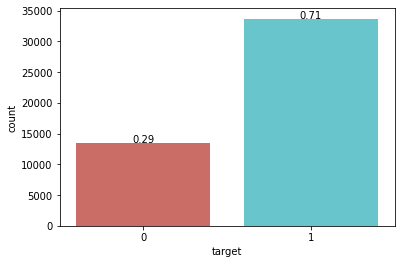

In [29]:
ax = sns.countplot(x='target',data=trnDf, palette='hls')
total = float(len(trnDf))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()

###### Train

In [30]:
y_train = trnDf['target']
X_train = trnDf[depVars]
X_train = sm.add_constant(X_train)

logreg = sm.Logit(y_train, X_train).fit()

print(logreg.summary2())

Optimization terminated successfully.
         Current function value: 0.565222
         Iterations 6
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.056     
Dependent Variable:       target                AIC:                   53370.0686
Date:                     2020-11-15 09:10      BIC:                   53422.6417
No. Observations:         47201                 Log-Likelihood:        -26679.   
Df Model:                 5                     LL-Null:               -28270.   
Df Residuals:             47195                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           6.0000                                                 
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------

In [33]:
y_train = trnDf['target']
depVars.remove('item_attempt_duration_mins')
X_train = trnDf[depVars]
X_train = sm.add_constant(X_train)

logreg = sm.Logit(y_train, X_train).fit()

print(logreg.summary2())

Optimization terminated successfully.
         Current function value: 0.565230
         Iterations 6
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.056     
Dependent Variable:       target                AIC:                   53368.8854
Date:                     2020-11-15 09:10      BIC:                   53412.6963
No. Observations:         47201                 Log-Likelihood:        -26679.   
Df Model:                 4                     LL-Null:               -28270.   
Df Residuals:             47196                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           6.0000                                                 
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------

In [36]:
logreg.params

const                               -0.199966
student_duration_mins                0.000709
timeliness_duration_mins             0.000003
item_type_code_name_swoe             0.979045
number_of_distinct_instance_items    0.008417
dtype: float64

ln( P / 1 - P) = -0.199966 + student_duration_mins * 0.000709 + timeliness_duration_mins * 0.000003 + item_type_code_name_swoe * 0.979045 + number_of_distinct_instance_items * 0.008417

###### Validate

In [34]:
y_valid = trnDf['target']
X_valid = trnDf[depVars]
X_valid = sm.add_constant(X_valid)

yhat = logreg.predict(X_valid)
prediction = list(map(round, yhat))

###### Reciever Operating Characteristic (ROC) Curve

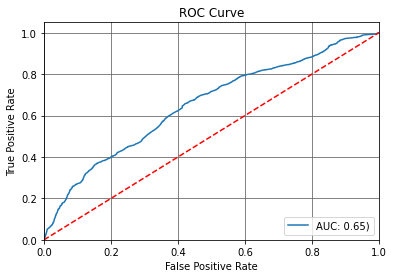

In [40]:
# Calculate TP, FP and AUC
fpr, tpr, thresholds = skm.roc_curve(y_valid, yhat)
roc_auc = skm.auc(fpr, tpr)

# Create ROC Plot
plt.figure()
plt.plot(fpr, tpr, label='AUC: %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

The area under curve (AUC) is .7. With a perfect AUC as 1, this means the model calculates true positives 70% of the time. Twenty percent better than at random.